In [1]:
import shnitsel as sh
import shnitsel.xarray
import matplotlib.pyplot as plt

In [2]:
frames = sh.open_frames('/nc/reports/2025-05-21_datasheets/filtered_C4H8_g0.nc')
frames

<xarray.Dataset> Size: 134MB
Dimensions:    (state: 3, frame: 36579, statecomb: 3, atom: 12, direction: 3,
                trajid_: 156)
Coordinates:
  * state      (state) int64 24B 1 2 3
  * atom       (atom) int64 96B 0 1 2 3 4 5 6 7 8 9 10 11
  * direction  (direction) <U1 12B 'x' 'y' 'z'
    atNames    (atom) <U1 48B ...
  * trajid_    (trajid_) int32 624B 2 3 6 11 13 16 ... 307 310 311 313 314 316
  * frame      (frame) object 293kB MultiIndex
  * trajid     (frame) int64 293kB 2 2 2 2 2 2 2 ... 316 316 316 316 316 316 316
  * time       (frame) float64 293kB 0.0 0.5 1.0 1.5 2.0 ... 76.5 77.0 77.5 78.0
  * statecomb  (statecomb) object 24B MultiIndex
  * from       (statecomb) int64 24B 1 1 2
  * to         (statecomb) int64 24B 2 3 3
Data variables: (12/13)
    energy     (state, frame) float64 878kB ...
    nacs       (statecomb, atom, direction, frame) float64 32MB ...
    atXYZ      (atom, direction, frame) float64 11MB ...
    sdiag      (frame) int64 293kB ...
    phases     (state, frame) float64 878kB ...
    e_kin      (frame) float64 293kB ...
    ...         ...
    dip_perm   (state, direction, frame) float64 3MB ...
    dip_trans  (statecomb, direction, frame) float64 3MB ...
    astate     (frame) int64 293kB ...
    completed  (frame, trajid_) int8 6MB ...
    nsteps     (frame, trajid_) int32 23MB ...
    max_ts     (frame, trajid_) int32 23MB ...
Attributes:
    delta_t:  0.5

Found following C-C bonds:


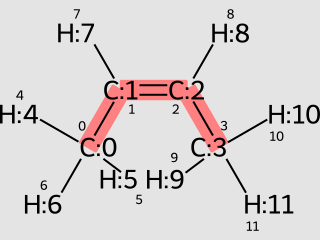

Remove 13 trajectories (3900 frames) containing C-C cleavage
with IDs: [233 206  19 270 260 288  68 310  77 151 274  64  61]
Found following C-H bonds:


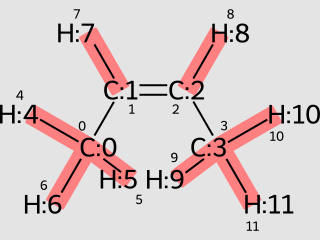

Remove 36 trajectories (7951 frames) containing C-H cleavage
with IDs: [129 276  54 142 184  82 161 191  97  78  52  11 162 179 190 108 217  33
 177  59 220 313  40 140  46 230 314  38 214   2 247  22  42  56 244 239]
Keep 107 trajectories (24728 frames)


In [3]:
# Select trajectories without cleavages
mol = sh.dynamic.filter_unphysical.mol_from_atXYZ(
    frames.atXYZ.isel(frame=0), to2D=False
)
frames.atXYZ.attrs['smiles_map'] = sh.dynamic.filter_unphysical.mol_to_numbered_smiles(mol)
frames = sh.dynamic.filter_unphysical.filter_cleavage(frames, CC=True, CH=True)

In [4]:
dih = frames.atXYZ.sh.dihedral(0, 1, 2, 3, full=False, deg=True)
dih

<xarray.DataArray 'dihedral' (frame: 24728)> Size: 198kB
array([  4.73905455,   5.31109479,   5.90918041, ..., 157.76520892,
       160.6599355 , 163.70932658], shape=(24728,))
Coordinates:
    atNames  <U1 4B 'C'
  * frame    (frame) object 198kB MultiIndex
  * trajid   (frame) int64 198kB 3 3 3 3 3 3 3 3 ... 316 316 316 316 316 316 316
  * time     (frame) float64 198kB 0.0 0.5 1.0 1.5 2.0 ... 76.5 77.0 77.5 78.0
Attributes:
    long_name:  $\varphi_{0,1,2,3}$

In [5]:
from sklearn.cluster import KMeans

### $k$-means clustering using final timestep

Text(0.5, 0, 'Final dihedral / °')

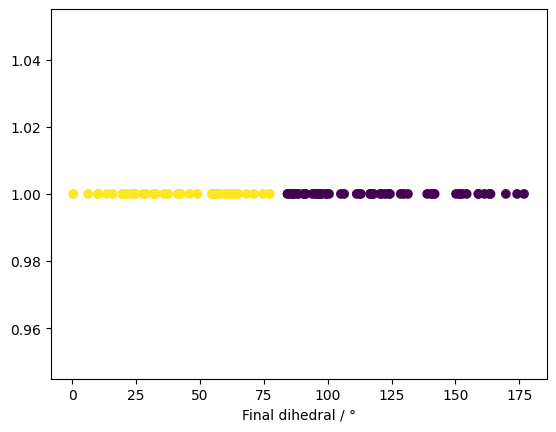

In [6]:
Y = dih.groupby('trajid').map(lambda traj: traj[{'frame': -1}])
kmc = KMeans(n_clusters=2)
kmc.fit(Y.data.reshape(-1, 1))
plt.scatter(Y, [1]*len(Y), c=kmc.predict(Y.data.reshape(-1, 1)))
plt.xlabel('Final dihedral / °')

### $k$-means clustering using final 2 timesteps

Text(0, 0.5, 'Final dihedral / °')

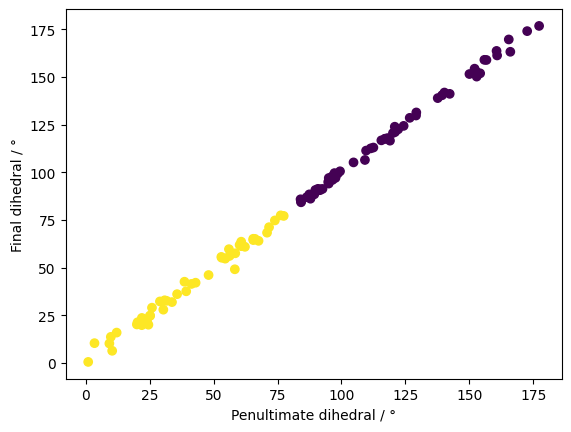

In [7]:
Y = dih.groupby('trajid').map(lambda traj: traj[{'frame': slice(-2, None)}].unstack('frame').assign_coords(time=[-2,-1]))
kmc = KMeans(n_clusters=2)
kmc.fit(Y)
plt.scatter(Y[:, 0], Y[:, 1], c=kmc.predict(Y))
plt.xlabel('Penultimate dihedral / °')
plt.ylabel('Final dihedral / °')

### -10 and -1

Text(0, 0.5, 'Final dihedral / °')

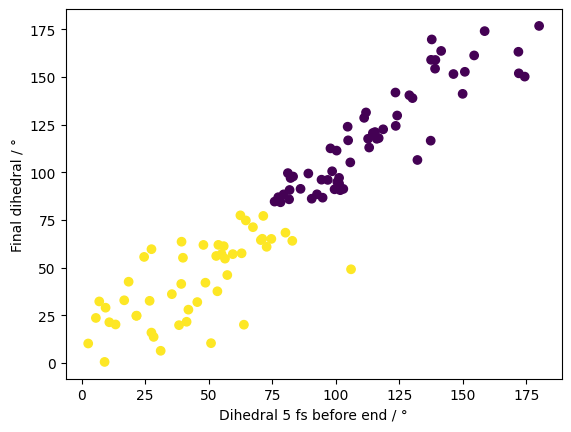

In [8]:
Y = dih.groupby('trajid').map(lambda traj: traj[{'frame': [-10, -1]}].unstack('frame').assign_coords(time=[-10,-1]))
kmc = KMeans(n_clusters=2)
kmc.fit(Y)
plt.scatter(Y[:, 0], Y[:, 1], c=kmc.predict(Y))
plt.xlabel('Dihedral 5 fs before end / °')
plt.ylabel('Final dihedral / °')

### $k$-means over the final 20 frames + PCA

In [10]:
def tmp(traj):
    traj = traj[{'frame': slice(-10, None)}]
    traj = traj.unstack('frame')
    traj = traj.assign_coords(time=range(-20, 0, 2))
    return traj

Ynew = dih.groupby('trajid').map(tmp)
Ynew

<xarray.DataArray 'dihedral' (trajid: 107, time: 10)> Size: 9kB
array([[  5.64752157,   8.1453756 ,  10.47262683, ...,  20.23339457,
         21.91291285,  23.52452811],
       [113.13209297, 112.71575564, 112.35484141, ..., 112.11863605,
        112.4753657 , 112.98520941],
       [158.54583984, 160.475003  , 162.36920858, ..., 171.09028853,
        172.636579  , 174.10539531],
       ...,
       [ 48.73524785,  48.31748718,  47.76531121, ...,  43.81589846,
         42.92979545,  42.01869604],
       [105.99774203, 103.88070313, 100.79622077, ...,  67.6743294 ,
         58.26819259,  49.06936358],
       [141.4378942 , 143.37239231, 145.43899028, ..., 157.76520892,
        160.6599355 , 163.70932658]], shape=(107, 10))
Coordinates:
  * trajid   (trajid) int64 856B 3 6 13 16 20 24 25 ... 303 304 306 307 311 316
    atNames  <U1 4B 'C'
  * time     (time) int64 80B -20 -18 -16 -14 -12 -10 -8 -6 -4 -2
Attributes:
    long_name:  $\varphi_{0,1,2,3}$

Text(0, 0.5, 'PC2')

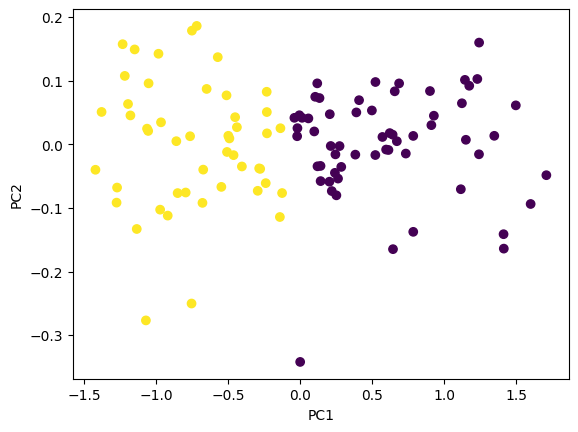

In [11]:
kmc = KMeans(n_clusters=2)
kmc.fit(Ynew)
pca_new = Ynew.sh.pca('time')
plt.scatter(pca_new[:, 0], pca_new[:, 1], c=kmc.predict(Ynew))
plt.xlabel('PC1')
plt.ylabel('PC2')